In [1]:
!pip install tensorflow pandas scikit-learn


In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

pd.set_option('display.max_columns',None)

In [3]:
def call_rmsle(y_true, y_pred):
    # Ensure predictions and true values are positive by adding 1
    y_true = tf.math.maximum(y_true, 0)
    y_pred = tf.math.maximum(y_pred, 0)

    # Compute the logarithm of the true and predicted values
    log_true = tf.math.log1p(y_true)
    log_pred = tf.math.log1p(y_pred)

    # Compute the squared difference
    squared_diff = tf.math.square(log_true - log_pred)

    # Compute the mean of the squared differences
    mean_squared_diff = tf.math.reduce_mean(squared_diff)

    # Return the square root of the mean squared differences
    return tf.math.sqrt(mean_squared_diff)

def remove_leading_zeros(df):
    # Find the index of the first non-zero sales value
    first_non_zero_index = df['sales'].ne(0).idxmax()

    # Filter the DataFrame to remove leading zeros
    return df.loc[first_non_zero_index:]

In [4]:
df_train_all    = pd.read_csv('data/SPX.csv')


In [5]:
df_train_all.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2024-08-19,5557.229980,5608.299805,5550.740234,5608.250000,5608.250000,3222050000
1255,2024-08-20,5602.879883,5620.509766,5585.500000,5597.120117,5597.120117,2994420000
1256,2024-08-21,5603.089844,5632.680176,5591.569824,5620.850098,5620.850098,3119670000
1257,2024-08-22,5637.770020,5643.220215,5560.950195,5570.640137,5570.640137,2981530000
1258,2024-08-23,5602.490234,5641.819824,5595.410156,5630.189941,5630.189941,688428450


In [6]:
df_train_all['10DMA'] =  df_train_all['Adj Close'].rolling(window=10).mean()
df_train_all['30DMA'] =  df_train_all['Adj Close'].rolling(window=30).mean()
df_train_all['100DMA'] =  df_train_all['Adj Close'].rolling(window=100).mean()


In [7]:
df_train_all.dropna(subset=['100DMA'], inplace=True)


In [8]:
import calendar
from datetime import datetime, timedelta
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0




In [9]:
df_train_all['Date'] = pd.to_datetime(df_train_all['Date'])

df_train_all['day'] = df_train_all['Date'].dt.day
df_train_all['month'] = df_train_all['Date'].dt.month
df_train_all['year'] = df_train_all['Date'].dt.year

df_train_all['opt_exp'] = df_train_all['Date'].apply(is_last_thursday)

In [10]:
df_train_all['year'] = df_train_all['year'] - df_train_all['year'].min()


# Convert month and day to cyclical features
#df_train_all['month_sin'] = np.sin(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['month_cos'] = np.cos(2 * np.pi * df_train_all['month'] / 12)
#df_train_all['day_sin'] = np.sin(2 * np.pi * df_train_all['day'] / 31)
#df_train_all['day_cos'] = np.cos(2 * np.pi * df_train_all['day'] / 31)



In [11]:
#df_train_all['price_next'] = df_train_all['Close'].shift(-1)
df_train_all['pct_change'] = df_train_all['Close']/df_train_all['Open']  
df_train_all['prev_close'] = df_train_all['Close'].shift(1)
df_train_all['opening_gap'] = df_train_all['Open'] - df_train_all['prev_close'] 
df_train_all['daily_move'] = df_train_all['High'] - df_train_all['Low']
df_train_all['daily_move']= df_train_all['daily_move'].shift(1) #previous day daily movement
df_train_all['daily_move_avg'] =  df_train_all['daily_move'].rolling(window=1).mean() #average of last 5 day movement
#df_train_all['price_lag2'] = df_train_all['Adj Close'].shift(2)
#df_train_all['price_lag3'] = df_train_all['Adj Close'].shift(3)
#df_train_all['price_lag4'] = df_train_all['Adj Close'].shift(4)
#df_train_all['price_lag5'] = df_train_all['Adj Close'].shift(5)

In [12]:
#df_train_all.dropna(subset=['price_lag5'], inplace=True)

In [13]:
df_train_all.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,pct_change,prev_close,opening_gap,daily_move,daily_move_avg
99,2020-01-15,3282.270020,3298.659912,3280.689941,3289.290039,3289.290039,3721490000,3262.983008,3207.589990,3069.029392,15,1,0,0,1.002139,NaN,NaN,NaN,NaN
100,2020-01-16,3302.969971,3317.110107,3302.820068,3316.810059,3316.810059,3540580000,3268.879004,3215.043661,3073.726392,16,1,0,0,1.004190,3289.290039,13.679932,17.969971,17.969971
101,2020-01-17,3323.659912,3329.879883,3318.860107,3329.620117,3329.620117,3726220000,3278.356006,3222.272331,3078.238794,17,1,0,0,1.001793,3316.810059,6.849853,14.290039,14.290039
102,2020-01-21,3321.030029,3329.790039,3316.610107,3320.790039,3320.790039,4104840000,3285.807007,3229.051001,3082.755095,21,1,0,0,0.999928,3329.620117,-8.590088,11.019776,11.019776
103,2020-01-22,3330.020020,3337.770020,3320.040039,3321.750000,3321.750000,3623780000,3294.264014,3234.912337,3087.093196,22,1,0,0,0.997517,3320.790039,9.229981,13.179932,13.179932
104,2020-01-23,3315.770020,3326.879883,3301.870117,3325.540039,3325.540039,3766710000,3301.513013,3241.231673,3091.102795,23,1,0,0,1.002947,3321.750000,-5.979980,17.729981,17.729981
105,2020-01-24,3333.100098,3333.179932,3281.530029,3295.469971,3295.469971,3708780000,3303.590015,3246.663338,3094.792896,24,1,0,0,0.988710,3325.540039,7.560059,25.009766,25.009766
106,2020-01-27,3247.159912,3258.850098,3234.500000,3243.629883,3243.629883,3831050000,3301.417993,3250.063338,3098.166494,27,1,0,0,0.998913,3295.469971,-48.310059,51.649903,51.649903
107,2020-01-28,3255.350098,3285.780029,3253.219971,3276.239990,3276.239990,3531570000,3300.229004,3253.652336,3101.551094,28,1,0,0,1.006417,3243.629883,11.720215,24.350098,24.350098
108,2020-01-29,3289.459961,3293.469971,3271.889893,3273.399902,3273.399902,3600250000,3299.254004,3257.138997,3104.525093,29,1,0,0,0.995118,3276.239990,13.219971,32.560058,32.560058


In [14]:
df_train_all.drop(['High','Low','Adj Close','daily_move','prev_close'],axis =1, inplace = True) 

In [15]:
df_train_all.tail()

,Date,Open,Close,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,pct_change,opening_gap,daily_move_avg
1254,2024-08-19,5557.229980,5608.250000,3222050000,5404.275049,5473.242057,5328.987324,19,8,4,0,1.009181,2.979980,36.810058
1255,2024-08-20,5602.879883,5597.120117,2994420000,5439.984082,5473.913395,5332.473623,20,8,4,0,0.998972,-5.370117,57.559571
1256,2024-08-21,5603.089844,5620.850098,3119670000,5482.119092,5473.478060,5336.138623,21,8,4,0,1.003170,5.969727,35.009766
1257,2024-08-22,5637.770020,5570.640137,2981530000,5507.252100,5473.014730,5339.407324,22,8,4,0,0.988093,16.919922,41.110352
1258,2024-08-23,5602.490234,5630.189941,688428450,5535.855078,5473.509391,5343.651123,23,8,4,0,1.004944,31.850097,82.270020


In [16]:
df_train_all.dropna(subset=['daily_move_avg'], inplace=True)


In [17]:
# df = df_train_all.copy()

In [18]:
# # Create lists to hold the new columns
# dates = []
# price_type = []
# prices = []

# # Populate the lists using iloc
# for i in range(len(df)):
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Open')
#     prices.append(df.iloc[i]['Open'])
    
#     dates.append(df.iloc[i]['Date'])
#     price_type.append('Close')
#     prices.append(df.iloc[i]['Close'])

# # Creating a new DataFrame with the desired format
# new_df = pd.DataFrame({
#     'Date': dates,
#     'Type': price_type,
#     'Price': prices
# })

# # Showing the result
# print(new_df.head())


In [19]:
df_train = df_train_all[df_train_all['Date']<=  '2023-08-23'] #keeping 4 years for training 
df_test  = df_train_all[df_train_all['Date']>  '2023-08-23'] #keeping last year for testing

In [20]:
df_lstm_results  = pd.DataFrame()

In [21]:
df_test.tail()

,Date,Open,Close,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,pct_change,opening_gap,daily_move_avg
1254,2024-08-19,5557.229980,5608.250000,3222050000,5404.275049,5473.242057,5328.987324,19,8,4,0,1.009181,2.979980,36.810058
1255,2024-08-20,5602.879883,5597.120117,2994420000,5439.984082,5473.913395,5332.473623,20,8,4,0,0.998972,-5.370117,57.559571
1256,2024-08-21,5603.089844,5620.850098,3119670000,5482.119092,5473.478060,5336.138623,21,8,4,0,1.003170,5.969727,35.009766
1257,2024-08-22,5637.770020,5570.640137,2981530000,5507.252100,5473.014730,5339.407324,22,8,4,0,0.988093,16.919922,41.110352
1258,2024-08-23,5602.490234,5630.189941,688428450,5535.855078,5473.509391,5343.651123,23,8,4,0,1.004944,31.850097,82.270020


In [22]:
          
df = df_train.copy()
df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################

# Features to be scaled
features_to_scale = ['Open', 'Close','Volume','10DMA','year','day','month','opening_gap','daily_move_avg']
#features_to_scale = ['Open', 'Close','Volume','10DMA','30DMA','100DMA','opening_gap','daily_move_avg']

# Features to be left unscaled (those ending with 'sin' or 'cos')
#features_to_leave = ['opt_exp','month_sin','month_cos','day_sin','day_cos' ]
features_to_leave = ['opt_exp' ]

features = features_to_scale + features_to_leave
#target = 'price_next'
target = 'pct_change'

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, shuffle=False)

#X_train = df[features]
#y_train = df[target]
# Initialize scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

# Scale only the selected features
X_train_scaled_part = feature_scaler.fit_transform(X_train[features_to_scale])
X_test_scaled_part = feature_scaler.transform(X_test[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_train_scaled = np.hstack((X_train_scaled_part, X_train[features_to_leave].values))
X_test_scaled = np.hstack((X_test_scaled_part, X_test[features_to_leave].values))

# Scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))



# Reshape data to fit LSTM input shape (num_samples, timesteps, num_features)
timesteps = 1  # You need to define this based on your data and model requirements
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))



In [23]:

# Build your LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(timesteps, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
#model.add(LSTM(256))
#model.add(Dropout(0.2))

model.add(Dense(1))

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with RMSLE as the loss function
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=call_rmsle )

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=100, 
                    validation_data=(X_test_reshaped, y_test_scaled), batch_size=64,callbacks=[early_stopping])


c:\Users\Monil\anaconda3\envs\python_312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.2187 - val_loss: 0.0879
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0825 - val_loss: 0.0619
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0706 - val_loss: 0.0472
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0742 - val_loss: 0.0456
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0646 - val_loss: 0.0454
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0685 - val_loss: 0.0453
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0698 - val_loss: 0.0529
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0695 - val_loss: 0.0469
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0687 - val_loss: 0.0509
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0682 - val_loss: 0.0558
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0649 - val_loss: 0.0481


In [24]:

##############################################################################################
#########################          Make Predictions              #############################
##############################################################################################


# Predictions
lstm_predictions = model.predict(X_test_reshaped)

# Ensure both predictions and actual values are of type float64
y_test_scaled = y_test_scaled.reshape(-1, 1).astype('float64')
lstm_predictions_scaled = lstm_predictions.astype('float64')

# Calculate RMSLE
lstm_rmsle_val = call_rmsle(y_test_scaled, lstm_predictions_scaled)

y_test_actual = target_scaler.inverse_transform(y_test_scaled).astype('float64')
lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')
lstm_rmsle_val_actual = call_rmsle(y_test_actual, lstm_predictions_actual)
print("RSMLE we got is ",lstm_rmsle_val_actual)

#

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
RSMLE we got is  tf.Tensor(0.003883264786873788, shape=(), dtype=float64)


## Applying model on Test Data

In [25]:
#############################################################################################
#########################             Applying model on test data       ######################
##############################################################################################

del df
df   = df_test.copy()

df.drop('Date',axis = 1, inplace = True)
###########################################################################################
###############     Preparing for LSTM              ######################################
#########################################################################################


# Scale only the selected features
X_test_scaled_part = feature_scaler.transform(df[features_to_scale])

# Combine scaled features with unscaled features (still as NumPy arrays)
X_test_scaled = np.hstack((X_test_scaled_part, df[features_to_leave].values))

X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

# Predictions
lstm_predictions = model.predict(X_test_reshaped)
lstm_predictions_scaled = lstm_predictions.astype('float64')

lstm_predictions_actual = target_scaler.inverse_transform(lstm_predictions_scaled).astype('float64')

# Add predictions to the dataframe
df_test['pct_change_predicted'] = lstm_predictions_actual



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


C:\Users\Monil\AppData\Local\Temp\ipykernel_35628\824153409.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pct_change_predicted'] = lstm_predictions_actual


In [26]:
#df_test['predicted_price_tomorrow'] = df_test['pct_change_predicted']*df_test['Close']
#df_test['predicted_price_today'] = df_test['predicted_price_tomorrow'].shift(1)
df_test['predicted_close'] = df_test['Open']*df_test['pct_change_predicted']

C:\Users\Monil\AppData\Local\Temp\ipykernel_35628\3203385979.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_close'] = df_test['Open']*df_test['pct_change_predicted']


In [27]:
df_test.head(100)

,Date,Open,Close,Volume,10DMA,30DMA,100DMA,day,month,year,opt_exp,pct_change,opening_gap,daily_move_avg,pct_change_predicted,predicted_close
1007,2023-08-24,4455.160156,4376.310059,3723470000,4413.566943,4492.587988,4310.980989,24,8,3,0,0.982301,19.150390,46.740235,1.000166,4455.897622
1008,2023-08-25,4389.379883,4405.709961,3296180000,4407.732959,4489.264323,4313.792991,25,8,3,0,1.003720,13.069824,82.750000,1.000113,4389.877309
1009,2023-08-28,4426.029785,4433.310059,2957230000,4402.091943,4486.281657,4317.120090,28,8,3,0,1.001645,20.319824,62.169922,1.000541,4428.425313
1010,2023-08-29,4432.750000,4497.629883,3354820000,4408.068946,4484.369987,4321.192590,29,8,3,0,1.014636,-0.560059,24.580079,0.999378,4429.993147
1011,2023-08-30,4500.339844,4514.870117,3064110000,4419.122949,4482.674984,4325.291091,30,8,3,0,1.003229,2.709961,68.459961,0.999581,4498.455651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,2024-01-10,4759.939941,4783.450195,3498680000,4747.181104,4683.711686,4469.366606,10,1,4,0,1.004939,3.439941,35.120117,0.999214,4756.200308
1103,2024-01-11,4792.129883,4780.240234,3759890000,4747.047119,4691.223356,4473.471909,11,1,4,0,0.997519,8.679688,34.599610,0.999233,4788.451924
1104,2024-01-12,4791.180176,4783.830078,3486340000,4747.095117,4698.998356,4477.312510,12,1,4,0,0.998466,10.939942,58.919922,0.999415,4788.376825
1105,2024-01-16,4772.350098,4765.979980,4260550000,4746.710107,4705.604362,4481.096812,16,1,4,0,0.998665,-11.479980,33.419922,0.997620,4760.990438


In [28]:
df_test.dropna(subset=['predicted_close'], inplace=True)

C:\Users\Monil\AppData\Local\Temp\ipykernel_35628\3938800536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(subset=['predicted_close'], inplace=True)


In [29]:
df_test[['Close','predicted_close']]

,Close,predicted_close
1007,4376.310059,4455.897622
1008,4405.709961,4389.877309
1009,4433.310059,4428.425313
1010,4497.629883,4429.993147
1011,4514.870117,4498.455651
...,...,...
1254,5608.250000,5554.720843
1255,5597.120117,5598.219822
1256,5620.850098,5600.438276
1257,5570.640137,5637.054207


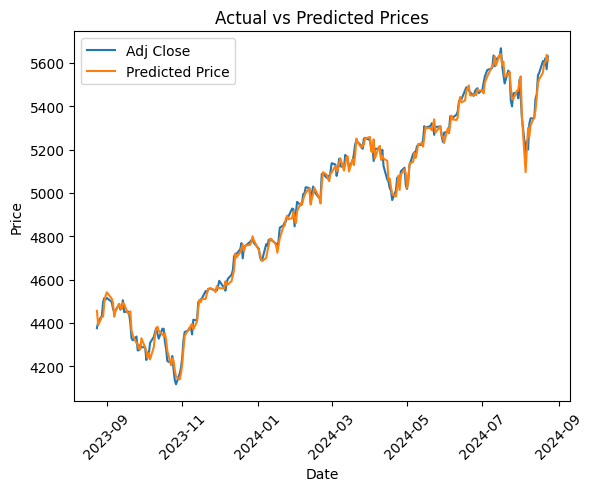

In [33]:
import matplotlib.pyplot as plt

# Plot the actual prices ('Close') and the predicted prices ('predicted_close')
plt.plot(df_test['Date'], df_test['Close'], label='Adj Close')
plt.plot(df_test['Date'], df_test['predicted_close'], label='Predicted Price')

# Add a title, labels, and legend
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()